In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
inspector = inspect(engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Inspect the columns in each table
measurementColumns = inspector.get_columns('measurement')
for column in measurementColumns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
stationColumns = inspector.get_columns('station')
for column in stationColumns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
# Find the most recent date in the data set.
for row in session.query(Measurement.date).order_by(Measurement.date.desc()).limit(1).all():
    print(row)
# Ordered by date, the most recent date is 2017-08-23

('2017-08-23',)


In [47]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
precipData = []

# Calculate the date one year from the last date in data set.
oneyear = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(oneyear)

# Perform a query to retrieve the data and precipitation scores, sort by date
for row in session.query(Measurement.date, Measurement.prcp, Measurement.tobs, Measurement.station).filter(Measurement.date > '2016-08-23').order_by(Measurement.date).all():
    precipData.append(row)

# Save the query results as a Pandas DataFrame and set the index to the date column
precipdf = pd.DataFrame(precipData, columns=['Date','Precipitation', 'TOBs', 'Station'])

# Instructions say to set index to the date, but this is not ideal for building charts. Copy the below code if index later needs to be set to the Date.
    # precipdf = precipdf.set_index('Date')


2016-08-23


In [48]:
# Drop NaN rows
precipdf.dropna(how="any", inplace=True)
precipdf

,Date,Precipitation,TOBs,Station
0,2016-08-24,0.08,79.0,USC00519397
1,2016-08-24,2.15,76.0,USC00513117
2,2016-08-24,2.28,80.0,USC00514830
4,2016-08-24,1.22,79.0,USC00519523
5,2016-08-24,2.15,77.0,USC00519281
...,...,...,...,...
2218,2017-08-22,0.50,76.0,USC00516128
2219,2017-08-23,0.00,81.0,USC00519397
2220,2017-08-23,0.00,82.0,USC00514830
2221,2017-08-23,0.08,82.0,USC00519523


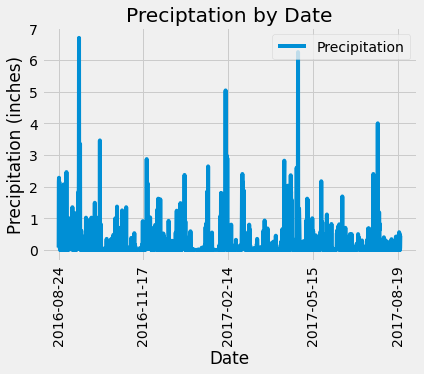

In [49]:
# Use Pandas Plotting with Matplotlib to plot the data

precipdf.plot(x="Date",y="Precipitation",rot = 90)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Preciptation by Date")
plt.legend(loc="upper right")
plt.show()

In [50]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipdf.describe()

,Precipitation,TOBs
count,2015.000000,2015.000000
mean,0.176462,74.484367
std,0.460288,4.629750
min,0.000000,58.000000
25%,0.000000,71.000000
50%,0.020000,75.000000
75%,0.130000,78.000000
max,6.700000,87.000000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
stations = session.execute('SELECT DISTINCT station from station').fetchall()
len(stations)


9

In [18]:
# Quick sanity check to ensure there are no stations with measurement recordings that don't exist in the table of stations
stations2 = session.execute('SELECT DISTINCT station from measurement').fetchall()
print(stations2)

[('USC00519397',), ('USC00513117',), ('USC00514830',), ('USC00517948',), ('USC00518838',), ('USC00519523',), ('USC00519281',), ('USC00511918',), ('USC00516128',)]


In [19]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

stationData = []
for row in session.query(Station.id, Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).all():
    stationData.append(row)
stationdf = pd.DataFrame(stationData, columns=['ID','Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])
stationdf

measureData = []
for row in session.query(Measurement.id, Measurement.station, Measurement.date, Measurement.prcp, Measurement.tobs).order_by(Measurement.date).all():
    measureData.append(row)
measuredf = pd.DataFrame(measureData, columns=['ID','Station', 'Date', 'Precip', 'TOBs'])



In [20]:
print(stationdf.head())

   ID      Station                                    Name  Latitude  \
0   1  USC00519397                    WAIKIKI 717.2, HI US   21.2716   
1   2  USC00513117                    KANEOHE 838.1, HI US   21.4234   
2   3  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US   21.5213   
3   4  USC00517948                       PEARL CITY, HI US   21.3934   
4   5  USC00518838              UPPER WAHIAWA 874.3, HI US   21.4992   

   Longitude  Elevation  
0  -157.8168        3.0  
1  -157.8015       14.6  
2  -157.8374        7.0  
3  -157.9751       11.9  
4  -158.0111      306.6  


In [32]:
# List the stations and the counts in descending order.
measuredf['Station'].value_counts()

USC00519281    2772
USC00519397    2724
USC00513117    2709
USC00519523    2669
USC00516128    2612
USC00514830    2202
USC00511918    1979
USC00517948    1372
USC00518838     511
Name: Station, dtype: int64

In [32]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
activeStation = measuredf.loc[measuredf['Station'] == 'USC00519281', :]
# measuredf columns=['ID','Station', 'Date', 'Precip', 'TOBs']
print(activeStation)
maxTemp = max(activeStation['TOBs'])
minTemp = min(activeStation['TOBs'])

          ID      Station        Date  Precip  TOBs
4      12188  USC00519281  2010-01-01    0.15  70.0
11     12189  USC00519281  2010-01-02    0.00  62.0
18     12190  USC00519281  2010-01-03    0.00  74.0
25     12191  USC00519281  2010-01-04    0.00  75.0
31     12192  USC00519281  2010-01-05    0.00  74.0
...      ...          ...         ...     ...   ...
19513  14955  USC00519281  2017-08-14    0.00  77.0
19518  14956  USC00519281  2017-08-15    0.32  77.0
19522  14957  USC00519281  2017-08-16    0.12  76.0
19526  14958  USC00519281  2017-08-17    0.01  76.0
19530  14959  USC00519281  2017-08-18    0.06  79.0

[2772 rows x 5 columns]


In [31]:
activeStation.describe()

,ID,Precip,TOBs
count,2772.000000,2772.000000,2772.000000
mean,13573.500000,0.212352,71.663781
std,800.351798,0.543312,4.357642
min,12188.000000,0.000000,54.000000
25%,12880.750000,0.000000,69.000000
50%,13573.500000,0.040000,72.000000
75%,14266.250000,0.190000,74.000000
max,14959.000000,9.640000,85.000000


            Date  Precipitation  TOBs      Station
5     2016-08-24           2.15  77.0  USC00519281
12    2016-08-25           0.06  80.0  USC00519281
19    2016-08-26           0.01  80.0  USC00519281
24    2016-08-27           0.12  75.0  USC00519281
30    2016-08-28           0.60  73.0  USC00519281
...          ...            ...   ...          ...
2186  2017-08-14           0.00  77.0  USC00519281
2191  2017-08-15           0.32  77.0  USC00519281
2195  2017-08-16           0.12  76.0  USC00519281
2199  2017-08-17           0.01  76.0  USC00519281
2203  2017-08-18           0.06  79.0  USC00519281

[351 rows x 4 columns]


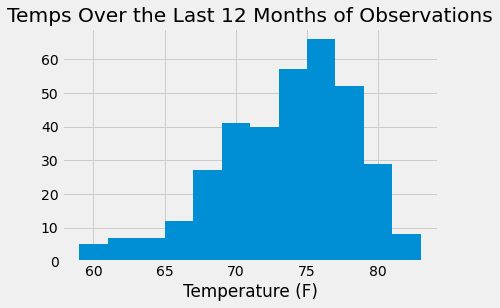

In [55]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
activeStationHist = precipdf.loc[precipdf['Station'] == 'USC00519281', :]
print(activeStationHist)
plt.hist(activeStationHist['TOBs'], bins=12)
plt.title('Temps Over the Last 12 Months of Observations')
plt.xlabel('Temperature (F)')
plt.show()

# Close session

In [54]:
# Close Session
session.close()